# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

For this project, we can see each of the following setups as outlined below, for necessary completion of the rubric points.  The next 5 sections expound on these details.

1. Load the data set 
2. Explore, summarize and visualize the data set
3. Design, train and test a model architecture
4. Use the model to make predictions on new images
5. Analyze the softmax probabilities of the new images
6. Summarize the results with a written report
 
 This here Jupyter notebook is the written report!


---
## Step 0: All needed imports

Useful for testing if environment is ready to rip

In [1]:
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.contrib.layers import flatten

print('Loaded all imports!')

/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/root/miniconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loaded all imports!


---
## Step 1: Load the data set

Retreived file via curl piping into a zip file and extracting.  Per project description, [dataset may be found at the provided link](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip)

In [2]:
# Load pickled data

training_file   = './train.p'
validation_file = './valid.p'
testing_file    = './test.p'

# sign names for labels
names_file      = './signnames.csv'

with open(names_file) as f:
    reader = csv.reader(f)
    next(reader) # skip first row
    names = {int(rows[0]):rows[1] for rows in reader}

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test   =  test['features'],  test['labels']

print('all done loading')

all done loading


---
## Step 2: Dataset Summary & Exploration

The next few section provide a snapshot of the data and visualizes some examples.

### Here is Basic Summary of the Data Set

In [8]:
# Number of training examples
n_train = np.shape(X_train)[0]

# Number of validation examples
n_validation = np.shape(X_valid)[0]

# Number of testing examples.
n_test = np.shape(X_test)[0]

# What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# How many unique classes/labels there are in the dataset.
sign_classes, class_counts = np.unique(y_train, return_counts = True)
num_classes = len(set(y_train)) # Original way I came up with, found this way above when needing to do augmentation

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", len(sign_classes))

Number of training examples = 27839
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### here is an exploratory visualization of the dataset

As can be clearly seen, the distribution of classes if very uneven


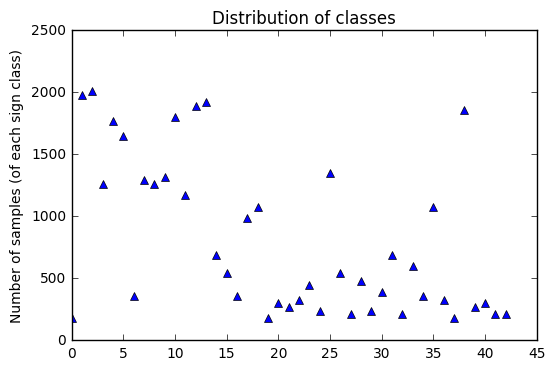

In [88]:
%matplotlib inline

plt.title("Distribution of classes")
plt.ylabel('Number of samples (of each sign class)')
chart = plt.plot(class_counts, 'b^')
#chart.set_xticklabels(names) #TODO Actually name the signs on the bar chart so we know what is underrepresented\
#plt.bar(x, y, width, color="blue")
plt.show()


### ...and finally,  a sampling of some images from the dataset

I ran this after shuffling and normalizing the dataset.  Hence no need to randomize index. Commented in case needed

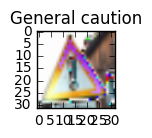

18


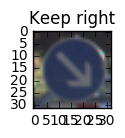

38


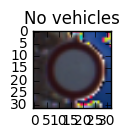

15


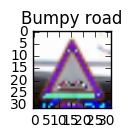

22


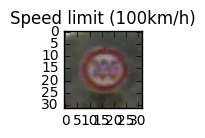

7


In [114]:
%matplotlib inline

for x in range(5):
    index = x #random.randint(0, len(X_train))
    image = X_train[index].squeeze()

    plt.figure(figsize=(1,1))
    plt.title(names[y_train[index]])
    #plt.subplot(1,10,x+1) # failed attempt to inline some of the images, not germane to this work
    plt.imshow(image) # showing with cmap='gray' does not have effect; per docs, if array depth is 3, then cmap is ignored
    plt.show()
    print(y_train[x])
    

----

## Step 3: Design, train and test a model architecture


Here we setup the model architecture, pre-process the data and other fun things. 

### Pre-process the Data Set (normalization, grayscale, etc.)

In [4]:
X_train, y_train = shuffle(X_train, y_train)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print('shuffled up and training/validation sets ready')

shuffled up and training/validation sets ready


In [5]:
def normalize(pixels):
    return (pixels - 128) / 128

X_train = normalize(X_train)
X_validation = normalize(X_validation)
X_test = normalize(X_test)

print('Images are now roughly normalized, hooray!')

Images are now roughly normalized, hooray!


### Model Architecture
#### Description
 
I feel the code below provides some of the relevant hyper-parameters used for tuning and the deep network architecture.  This is basically a copy of the LeNet solution, with DropOut and regularization added being the main difference.  In addition, one of the fully-connected layers was dropped.  The other main difference is the depths for the convolution layers were upped a bit more as the LeNet solution was for 10 classes, and since we have 43, there are surely more finer-grained features to learn. 


In [9]:

EPOCHS = 500
BATCH_SIZE = 1024 #orig 128
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.16

# Declaring weights outside method for access later.  CLEANME: Move this to a proper class
depth_conv1 = 6
depth_conv2 = 16
size_fc_1 = 120
size_fc_2 = 84

conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, depth_conv1), mean = mu, stddev = sigma))
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, depth_conv1, depth_conv2), mean = mu, stddev = sigma))
fc1_W = tf.Variable(tf.truncated_normal(shape=(5*5*depth_conv2, size_fc_1), mean = mu, stddev = sigma))
fc2_W  = tf.Variable(tf.truncated_normal(shape=(size_fc_1, size_fc_2), mean = mu, stddev = sigma))
fc3_W  = tf.Variable(tf.truncated_normal(shape=(size_fc_2, num_classes), mean = mu, stddev = sigma))
keep_prob = tf.placeholder(tf.float32) # probability to keep units

def LeNet(x):    
    print("Charging up!")

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28xdepth_conv1.
    conv1_b = tf.Variable(tf.zeros(depth_conv1))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    #conv1 =  tf.nn.dropout(conv1, keep_prob)
    
    # Pooling. Input = 28x28xdepth_conv1. Output = 14x14xdepth_conv1.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10xdepth_conv2.
    conv2_b = tf.Variable(tf.zeros(depth_conv2))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    #conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10xdepth_conv2. Output = 5x5xdepth_conv2.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5xdepth_conv2. Output = 1800.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1800. Output = size_fc_1.
    fc1_b = tf.Variable(tf.zeros(size_fc_1))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    #fc1    = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 3: Fully Connected. Input = size_fc_1. Output = size_fc_2.
    fc2_b  = tf.Variable(tf.zeros(size_fc_2))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 4: Fully Connected. Input = size_fc_2. Output = num_classes.
    fc3_b  = tf.Variable(tf.zeros(num_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, num_classes)

print('All done')

All done


### Train, Validate and Test the Model

In [10]:
%%time

rate = 0.00175
largeBiasPenalty = 0.025
keep_probability = 0.79

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# Add regularization to the loss for highly-biased weights
loss_operation = tf.reduce_mean(cross_entropy) + \
    largeBiasPenalty * tf.nn.l2_loss(conv1_W) +\
    largeBiasPenalty * tf.nn.l2_loss(conv2_W) +\
    largeBiasPenalty * tf.nn.l2_loss(fc1_W) +\
    largeBiasPenalty * tf.nn.l2_loss(fc2_W) +\
    largeBiasPenalty * tf.nn.l2_loss(fc3_W)
    
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffick')
    print("Model saved")
    

### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

Charging up!
Training...

EPOCH 1 ...
Validation Accuracy = 0.214

EPOCH 2 ...
Validation Accuracy = 0.427

EPOCH 3 ...
Validation Accuracy = 0.520

EPOCH 4 ...
Validation Accuracy = 0.544

EPOCH 5 ...
Validation Accuracy = 0.637

EPOCH 6 ...
Validation Accuracy = 0.666

EPOCH 7 ...
Validation Accuracy = 0.714

EPOCH 8 ...
Validation Accuracy = 0.739

EPOCH 9 ...
Validation Accuracy = 0.725

EPOCH 10 ...
Validation Accuracy = 0.737

EPOCH 11 ...
Validation Accuracy = 0.752

EPOCH 12 ...
Validation Accuracy = 0.751

EPOCH 13 ...
Validation Accuracy = 0.756

EPOCH 14 ...
Validation Accuracy = 0.771

EPOCH 15 ...
Validation Accuracy = 0.784

EPOCH 16 ...
Validation Accuracy = 0.790

EPOCH 17 ...
Validation Accuracy = 0.766

EPOCH 18 ...
Validation Accuracy = 0.800

EPOCH 19 ...
Validation Accuracy = 0.778

EPOCH 20 ...
Validation Accuracy = 0.791

EPOCH 21 ...
Validation Accuracy = 0.801

EPOCH 22 ...
Validation Accuracy = 0.793

EPOCH 23 ...
Validation Accuracy = 0.776

EPOCH 24 ...
Vali

KeyboardInterrupt: 

And what do we get!!??  PASS!!!!

In [133]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Test Accuracy = 0.932
CPU times: user 16.3 s, sys: 3.6 s, total: 19.9 s
Wall time: 15.4 s


In [133]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Test Accuracy = 0.932
CPU times: user 16.3 s, sys: 3.6 s, total: 19.9 s
Wall time: 15.4 s


---
## Step 4: Use the model to make predictions on new images


Here we download 5 images from the web to test our dataset against.  I added a sixth image.  For some silly reason when I first started, I sought out traffic signs that are _not_ in the dataset (we, afterall, have a test set for verifying overall accuracy anyway).  So I included a sixth one, a Tank-cross sign, which doesn't exist in the dataset, to see how easily the model may be fooled.




### Load and Output the Images

size of tank: (32, 32, 3) 


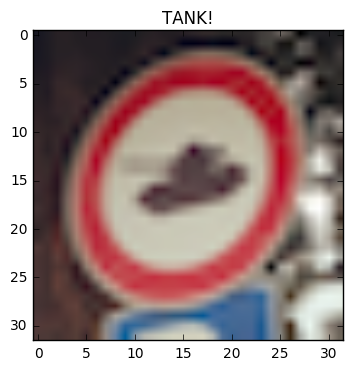

size of animal: (32, 32, 3) 


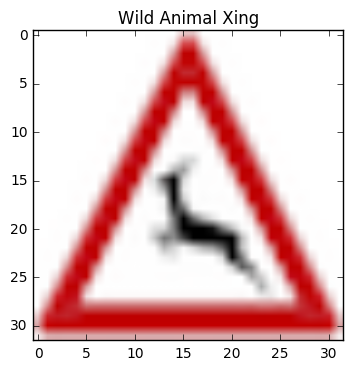

size of general_caution: (32, 32, 3) 


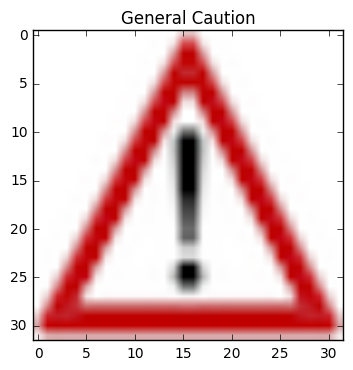

size of dangerous_left: (32, 32, 3) 


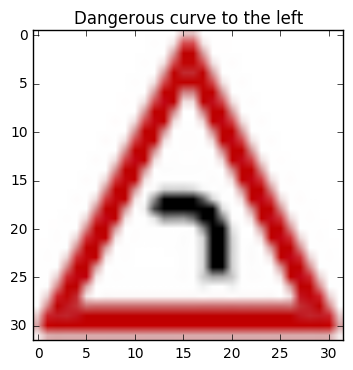

size of kph_60: (32, 32, 3) 


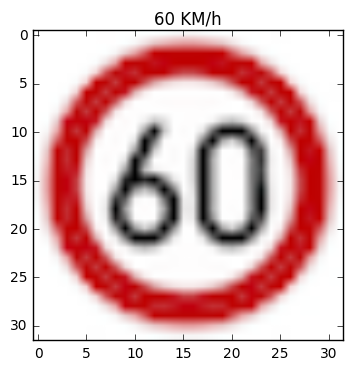

size of kph_30: (32, 32, 3) 


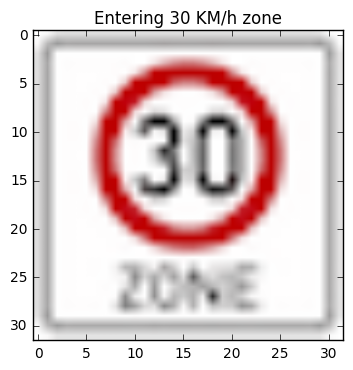

(6, 32, 32, 3)


In [113]:
# class id = NONE!
tank = mpimg.imread('downloaded/tank.png')
print('size of tank: {} '.format(np.shape(tank)))

# It seems like mpimg is already 'normalizing' the images as we read them.  Or it was OSX Preview as I reshapped the classes.
#print('full output of tank: {}'.format(tank))
#print('normalizing tank: {}'.format(normalize(tank)))

plt.title('TANK!')
plt.imshow(tank)
plt.show()

# class id = 31
wild_animals = mpimg.imread('downloaded/847px-Zeichen_142-10_-_Wildwechsel,_Aufstellung_rechts,_StVO_1992.svg.png')
print('size of animal: {} '.format(np.shape(wild_animals)))
plt.title('Wild Animal Xing')
plt.imshow(wild_animals)
plt.show()

# class id = 18
general_caution = mpimg.imread('downloaded/Zeichen_101_-_Gefahrstelle,_StVO_1970.svg.png')
print('size of general_caution: {} '.format(np.shape(general_caution)))
plt.title('General Caution')
plt.imshow(general_caution)
plt.show()

# class id = 19
dangerous_left = mpimg.imread('downloaded/Zeichen_103-10_-_Kurve_(links),_StVO_1992.svg.png')
print('size of dangerous_left: {} '.format(np.shape(dangerous_left)))
plt.title('Dangerous curve to the left')
plt.imshow(dangerous_left)
plt.show()


# class id = 3
kph_60 = mpimg.imread('downloaded/Zeichen_274-56.svg.png')
print('size of kph_60: {} '.format(np.shape(kph_60)))
plt.title('60 KM/h')
plt.imshow(kph_60)
plt.show()

# class id 1
kph_30 = mpimg.imread('downloaded/Zeichen_274.1_-_Beginn_einer_Tempo_30-Zone,_StVO_2013.svg.png')
print('size of kph_30: {} '.format(np.shape(kph_30)))
plt.title('Entering 30 KM/h zone')
plt.imshow(kph_30)
plt.show()



X_downloaded = [tank, wild_animals, general_caution, dangerous_left, kph_60, kph_30]
y_downloaded = [-1,31,18,19,3,1]

print(np.shape(X_downloaded))

---
## Step 5 Analyze the softmax probabilities of the new images Test a Model on New Images

### Predict the Sign Type for Each Image

In [ ]:
%%time

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_downloaded, y_downloaded)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [108]:
# function to print out softmax
# It may be a bit more optimized to run this during accuracy option. But not needed for this project's purposes

top5 = tf.nn.top_k(tf.nn.softmax(logits), k=5)

def eval_downloaded(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    t5 = sess.run(top5, feed_dict={x: X_data, y: y_data, keep_prob: 1.0})
    print("TOP5   {}".format(maybe_t5))
    return t5

print('Eval with top5 function loaded')

Eval with top5 function loaded


In [ ]:
%%time

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5_accuracy = eval_downloaded(X_downloaded, y_downloaded)
    print("top 5 matrix in full = {}".format(top5_accuracy))


---
## Step 6 Project Writeup

This here Jupyter notebook acts as my writeup!


Overall, I had a frustrating time on this project, as fun as it was to play around with tensorflow and learn actual traffic signs.  Due to work obligations, I could realisitically only commit an hour or two per day to this project.  The majority of my time I spent spinning my wheels due to trying to get the saved model to restore from the saved checkpoint.  Using 'last checkpoint' works fine, but the other approaches as documented in the TensorFlow documentation and Udacity class only resulted in errors.  


I also was surprised that the LeNet architecture worked prefectly fine, even without normalization and in spite of the fact it had been setup for 10-class problem, rather than the 43-class problem we currently have.  Also surprising is adding dropout dramatically decreased the accuracy.  I noticed that, in spite of a lot of parameters, there seemed to be a local optima that kept accuracy stuck at exactly 5.4%.  Sometimes, I would let the model run for 70 epochs and then it would rapidally get close to 95% accuracy after getting out of the 5.4% rut it was in.


I do not agree with augmenting the dataset, despite explicit hints provided, and feel it's important to construct a deep net that realisitically simulates learning conditions of the real world.  Even better would be to use few examples.  The average human, in their lifetime, would not need to see 100,000+ examples of traffic signs repeatedly in order to accurately predict them.   Granted, we are also in these training sets teaching a net to read images.  It would be nice if there were preconfigured nets that already understand how to read images, that then feed into one specifically for traffic signs. Some of my comments are inspired by a tweet from Yan Lecunn, I'll let it speak for itself when he was congratulating Alpha Go on its achievements, and then challenged them to do the same with far less examples and reinforcement learning.  [Yann's tweet](https://twitter.com/ylecun/status/708732919548919808)

In either case I was able to get the minimun necessary accuracy.


Some other observations:
- I tried to apply the "keep calm and lower your learning rate" trick.  I was giving values as low as a magnitude of 10e-10 and I still constantly kept getting stuck in the 5% rut.  I reread what the Adam optimizer is and realize it applies the learn-rate lowering throughout repeated iterations, so I embraced a higher learning rate and that did a much better job of not being stuck in the 5% gutter. 
- I removed a fully-connected layer.  It took a lot more cajoling to get results above 90%, so I brought it back. 
- I used a lazy-person's stop for overregularization.  By saving the model after each epoch, I could keep my eye on when it reached a satisfactory accuracy, and stop as needed.  I thought about applying a simple-moving average to only stop when the rate of accuracy decreases after X epochs, but since I wasn't sure what values to use, and sometimes it would take dozens of minutes to reach a certain state, I would hate for things to stop.  So I used an overly large number of epochs, with manual stopping.
- Strangley, dropout and regularization seemed to make things worst

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.